<a href="https://colab.research.google.com/github/annabuklya/AdvancedPython/blob/master/Volkova_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
sns.set_style("whitegrid")

## Белые мышки

**Практика**

Дан <a href="https://www.kaggle.com/ruslankl/mice-protein-expression
">датасет</a> с данными об экспрессии белков у белых мышей. Данный датасет состоит из таблицы значений уровней экспрессии 77 различных белков в мозге у мышей. Каждая строка соответствует одной особи, каждый столбец соответствует одному белку.

In [ ]:
df = pd.read_csv("./Data_Cortex_Nuclear.csv") 

Выберем для анализа белки ITSN1_N, DYRK1A_N, pBRAF_N, pCREB_N.

Построим гистограммы изучаемых признаков.

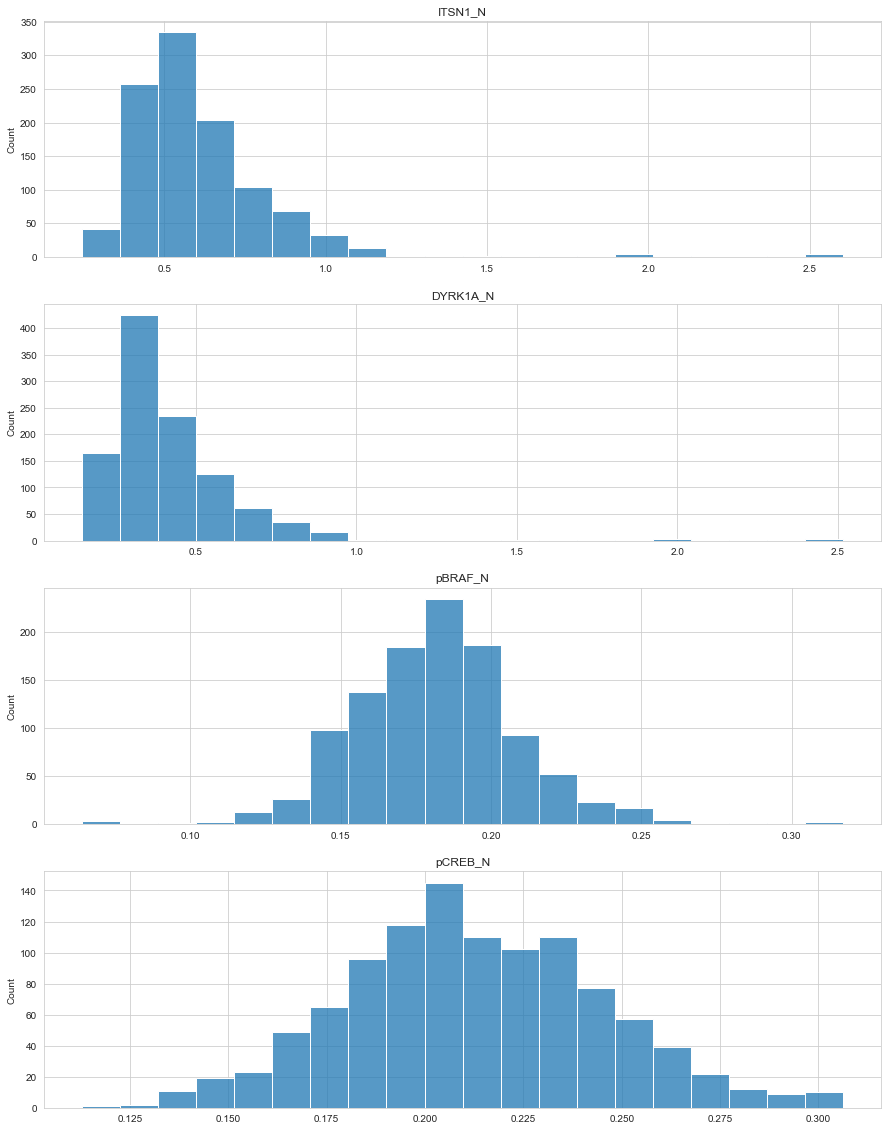

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(15,20))
for a,i in zip(ax,columns):
    sns.histplot(np.array(df_chosen_columns[i]), ax=a, label= i, bins=20)
    a.set_title(i)
    

Выкинем выбросы

In [ ]:
ranges = [(0,1.2),(0,1),(0.1, 0.27), (min(df_chosen_columns[columns[3]]),max(df_chosen_columns[columns[3]]))]
data = dict()
for i in range(4):
    df_chosen_columns[columns[i]].dropna()
    a = df_chosen_columns[columns[i]]
    data[columns[i]] = a[(a < ranges[i][1]) & (a >= ranges[i][0])]

После фильтрации:

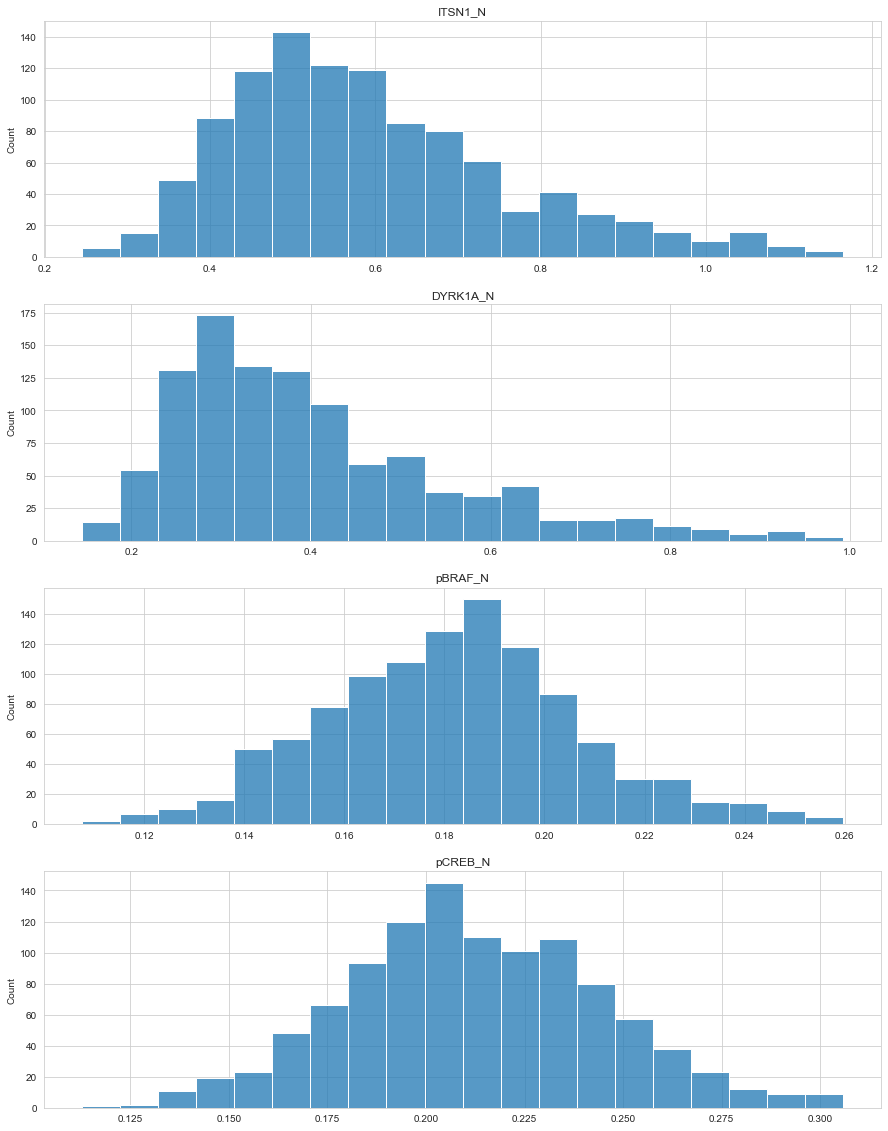

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(15,20))
for a,i in zip(ax,columns):
    sns.histplot(np.array(data[i]), ax=a, label= i, bins=20)
    a.set_title(i)
    

**1.** 

Найдем оценки максимального правдоподобия (ОМП).

Предположим, что признаки имеют следующие распределения: 


*   'pBRAF_N' и 'pCREB_N' &mdash; нормальное распределение с неизвестными параметрами $\theta = (a, \sigma^2)$;
*  'ITSN1_N' &mdash; гамма-распределение $Gamma(\theta, \beta)$ с плотностью $p_{\theta}(x) = \frac{\theta^{\beta} x^{\beta-1}}{\Gamma(\beta)} e^{-\theta x} $ с неизвестным параметром $\theta$ и известным параметром $\beta$, равным 13.5;
* 'DYRK1A_N' &mdash; гамма-распределение $Gamma(\theta, \beta)$ с неизвестным параметром $\theta$ и известным параметром $\beta$, равным 9.


In [ ]:
#pbaf, pcreb
feat = ['pBRAF_N', 'pCREB_N']
est ={feature: np.mean(data[feature]) for feature in feat} 
disp = {feature: S2(data[feature]) for feature in feat} #оценкой sigma^2 можно считать несмещенную S2 из задания 1
#остальные 
feat = ['ITSN1_N', 'DYRK1A_N']
beta = { 'ITSN1_N': 13.5, 'DYRK1A_N': 9} 
for feature in feat:
    est[feature] = np.mean(data[feature])/beta[feature] 


In [ ]:
columns = columns[::-1]
columns

['pCREB_N', 'pBRAF_N', 'DYRK1A_N', 'ITSN1_N']

Построим для каждого признака на одном графике гистограмму каждого признака, график ядерной оценки плотности и график плотности распределения с параметрами, являющимися полученной ОМП.Сравним получившиеся результаты. Сделаем выводы.

In [ ]:
funcs = [sps.norm(est[i],np.sqrt(disp[i])) for i in columns[:2]]
funcs += [sps.gamma(a=beta[i],scale=est[i]) for i in columns[2:]]


In [ ]:
grids = [np.linspace(*i,1000) for i in [[0.1,0.32], [0.1,0.26],[0.1,1],[0.2,1.2]]]

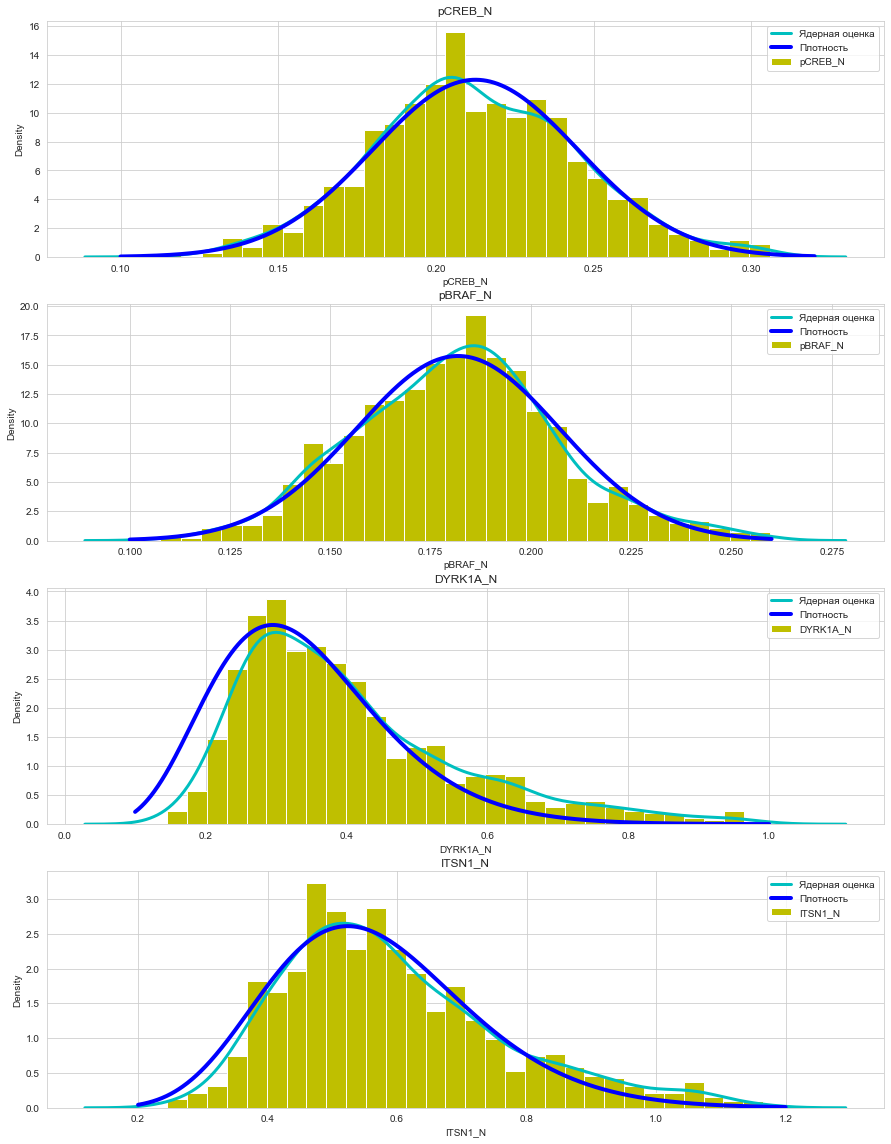

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(15,20))

for a,i,n in zip(ax,columns, range(4)):
    a.hist(np.array(data[i]), label= i, bins=30,density=True, color='y')
    sns.kdeplot(data=data[i], label='Ядерная оценка', color='c',ax=a, lw=3)
    a.plot(grids[n], funcs[n].pdf(grids[n]), color='b', label = 'Плотность', lw=4)
    a.set_title(i)
    a.legend()

**Вывод** Как видно, посчитанные оценки хорошо аппроксимируют полученные данные и ядерная оценка плотности близка к распределениям с посчитанными оценками. Виден некоторый сдвиг ядерной оценки относительно гамма распределения, но скорее всего на выборках большего размера, они были бы ближе, вряд ли ошибка в подсчете параметров (сложно ошибиться в делении среднего на заданную константу). Очевидно, что выбросы сбили бы большую часть оценок и рисунок был бы куда хуже, чем после фильтрации.

**2.**


Реализуйте функции, возвращающие значения функции правдоподобия  и логарифмической функции правдоподобия для гамма распределения с параметрам $\theta, \beta$.


In [ ]:
import numpy as np
from scipy.special import loggamma, factorial, gamma
#из моего же контеста + вроде нет смысла подробно обосновывать взятие логарифма (?)
def gamma_pdf(x, theta, beta):
    return theta ** beta * x ** (beta -1) * np.exp(-theta * x)/gamma(beta)

def loggamma_pdf(x, theta, beta):
    return beta * np.log(theta) + (beta - 1)*np.log(x) - loggamma(beta) - theta * x
    
def gamma_likelihood(x: np.ndarray, theta: float, beta: float) -> float:
    return np.prod(theta ** beta * x ** (beta -1) * np.exp(-theta * x)/gamma(beta))


def gamma_loglikelihood(x: np.ndarray, theta: float, beta: float) -> float:
    return np.sum(beta * np.log(theta) + (beta - 1)*np.log(x) - loggamma(beta) - theta * x)



Выведем следующие значения:
- функции правдоподобия;
- логарифма, взятого от функции правдоподобия;
- логарифмической функции правдоподобия

на следующих реализациях выборок:
- `np.ones(5)*5` &mdash; 5 пятерок;
- `np.ones(500)*5`&mdash; 500 пятерок;
- `np.ones(500)*5`&mdash; 5000 пятерок;
- `np.ones(5)*500`.

Параметр $\beta$ положим равным 10, параметр $\theta$ положим равным 2.

Сделаем выводы, какую функцию лучше вычислять на практике


In [ ]:
samples = [np.ones(5)*5,np.ones(500)*5, np.ones(5000)*5,np.ones(5)*500 ]
theta = 2
beta = 10
for i in range(4):
    print('Выборка - ' + str(i + 1))
    print('Likelyhood', gamma_likelihood(samples[i], theta, beta))
    print('LogLikelyhood', gamma_loglikelihood(samples[i], theta, beta))   
    print('log(Likelyhood)', np.log(gamma_likelihood(samples[i], theta, beta)))
    print('-------------------------------')

Выборка - 1
Likelyhood 0.0009808683444336409
LogLikelyhood -6.927072312875575
log(Likelyhood) -6.927072312875565
-------------------------------
Выборка - 2
Likelyhood 1.4490116504598503e-301
LogLikelyhood -692.7072312875573
log(Likelyhood) -692.7072312875565
-------------------------------
Выборка - 3
Likelyhood 0.0
LogLikelyhood -6927.072312875575
log(Likelyhood) -inf
-------------------------------
Выборка - 4
Likelyhood 0.0
LogLikelyhood -4749.694413943412
log(Likelyhood) -inf
-------------------------------


/tmp/ipykernel_148241/3196165196.py:8: RuntimeWarning: divide by zero encountered in log
  print('log(Likelyhood)', np.log(gamma_likelihood(samples[i], theta, beta)))


**Вывод:**

Как видно, на маленьких выборках различия между значениями почти незаметны. Однако, видим, что если значени выборки большие (выборка 4), то значения плотности стремятся к нулю, соответственно множественное произведение таких величин стремится к нулю (возможно при вычислениях компьютера становится меньше машинного эпсилон, то есть для компьютера это чистый ноль. То же самое будет если взять большую выборку не с такими большими значениями(выборка 3). Для нее будет множественное произведение не столь малых величин, но тем не менее это все равно станет меньше машинного эпсилон (тк значение - ноль). И таким образом в этих двух случаях получаем абсолютно не информативные значения функции правдоподобия и ее логарифма. однако логарифмическая функция вычисленная "честно" не обращается в ноль и дает высокую точность "побеждая" логарифм, и при это не скатывается в константу (в ноль из-за машинной точности) как функция правдоподобия. таким образом лучше всего смотреть на loglikelyhood.

**3.** 

Теперь подберем параметр $\beta$ для гамма-распределения с помощью перебора. 

Рассмотрим признаки 'ITSN1_N', 'DYRK1A_N'. В каждом случае сгенерируем одномерную сетку (grid) и переберем параметр $\beta$ по сетке с шагом $10^{-4}$. 

Вычислим для каждого $\beta$  параметр $\theta$ по теоретической формуле, которую реализовали в прошлой части задачи. 

Посчитаем (логарифмическую) функцию правдоподобия для полученных параметров $\beta, \theta$ и выберем наилучший параметр на основании значений этой функции. 

Выведем значения полученных параметров с точностью 4 знака после запятой.

Также построим графики зависимости значений функций правдоподобия от $\beta$. Сделаем вывод.


Подбирая интервал для отоборажения в окрестности указанной бета в конечном итоге, уменьшая последовательно интервал можем видеть картинки снизу.

[0.01774003 0.02661005]


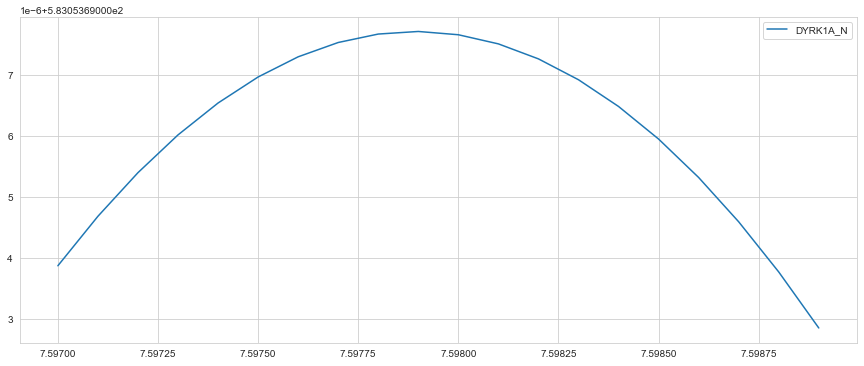

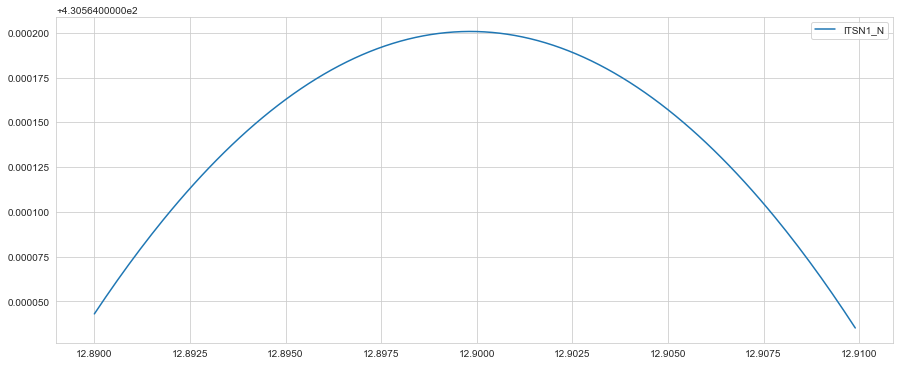

In [ ]:
feats = columns[2:]
means = np.array([np.mean(data[i]) for i in feats])
#print(est)
#print(means)
#beta = theta * Ex
a = np.array(list(est.values())[2:])
print(a * means) # примерные beta пойдем от 0.01 до 0.03 для первого и от 0.02 до 0.04
grids_b = [np.arange(7.597,7.599,1e-4), np.arange(12.89,12.91, 1e-4)]
thetas = [grids_b[i]/means[i] for i in range(2)]
ll = [[gamma_loglikelihood(data[feats[j]], theta, beta) for theta,beta in zip(thetas[j],grids_b[j])] for j in range(2)]

for i in range(2):
    plt.figure(figsize=(15,6))
    plt.plot(grids_b[i], ll[i], label=feats[i])
    plt.legend()

In [ ]:
beta_0 = [grids_b[i][0] + np.argmax(ll[i]) * 1e-4 for i in range(2)]
for i in range(2):
    print(feats[i], '-', beta_0[i])
    
beta_s = [9, 13.5]

DYRK1A_N - 7.5979
ITSN1_N - 12.8998


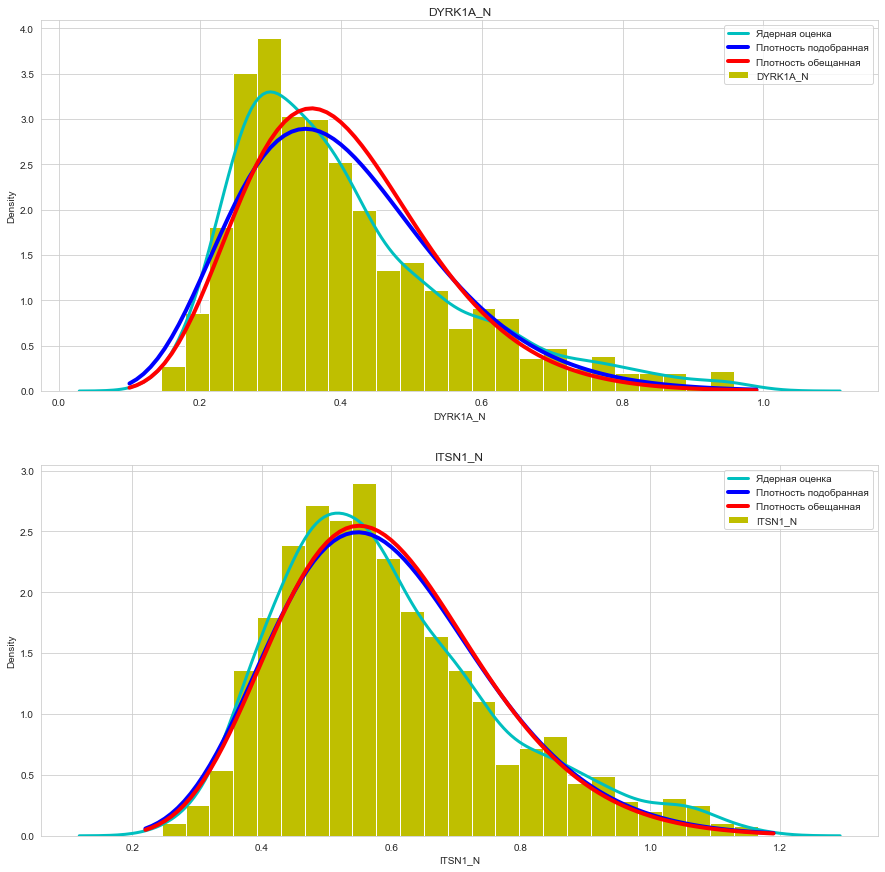

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(15,15))

for a,i,n in zip(ax,feats, range(2)):
    a.hist(np.array(data[i]), label= i, bins=25,density=True, color='y')
    sns.kdeplot(data=data[i], label='Ядерная оценка', color='c',ax=a, lw=3)
    a.plot(grids[n], gamma_pdf(grids[n],beta_0[n]/np.mean(data[i]), beta_0[n]), color='b', label = 'Плотность подобранная', lw=4)
    a.plot(grids[n], gamma_pdf(grids[n],beta_s[n]/np.mean(data[i]), beta_s[n]), color='r', label = 'Плотность обещанная', lw=4)
    a.set_title(i)
    a.legend()
    

**Вывод** Значения точки максимума функции правдоподобия (в данном случае логарифмической) отвечают ОМП параметра бета и соответственно после пересчета - тета. Видно что значения близки к заявленным, но не совсем такие. На графике сравнения можно видеть, что полученные оценки больше похожи на правду (тк пик плотности сдвигается ближе к пику гистограммы (что означает более правильную оценку). Так как во втором случае отличие параметров не такое большое, графики плотности слабо отличаются. Полученная методом перебора оценка оказалась точнее данной в условии(что объяснимо тем, что мы не знаем откуда взялись эти числа), и, вероятно, при большей выборке еще лучше бы описывала происходящее. Обе оценки заметно отстоят от ядерной оценки плотности, но все таки выборка не такая большая, чтобы принимать значения KDE, как истину.

Построим для каждого признака на одном графике гистограмму каждого признака, график ядерной оценки плотности и график плотности распределения с параметрами, являющимися полученной ОМП. Графики для разных признаков стройте на разных графиках, но в одном окне. Сравним получившиеся результаты с результатами, полученными в первой части задачи.

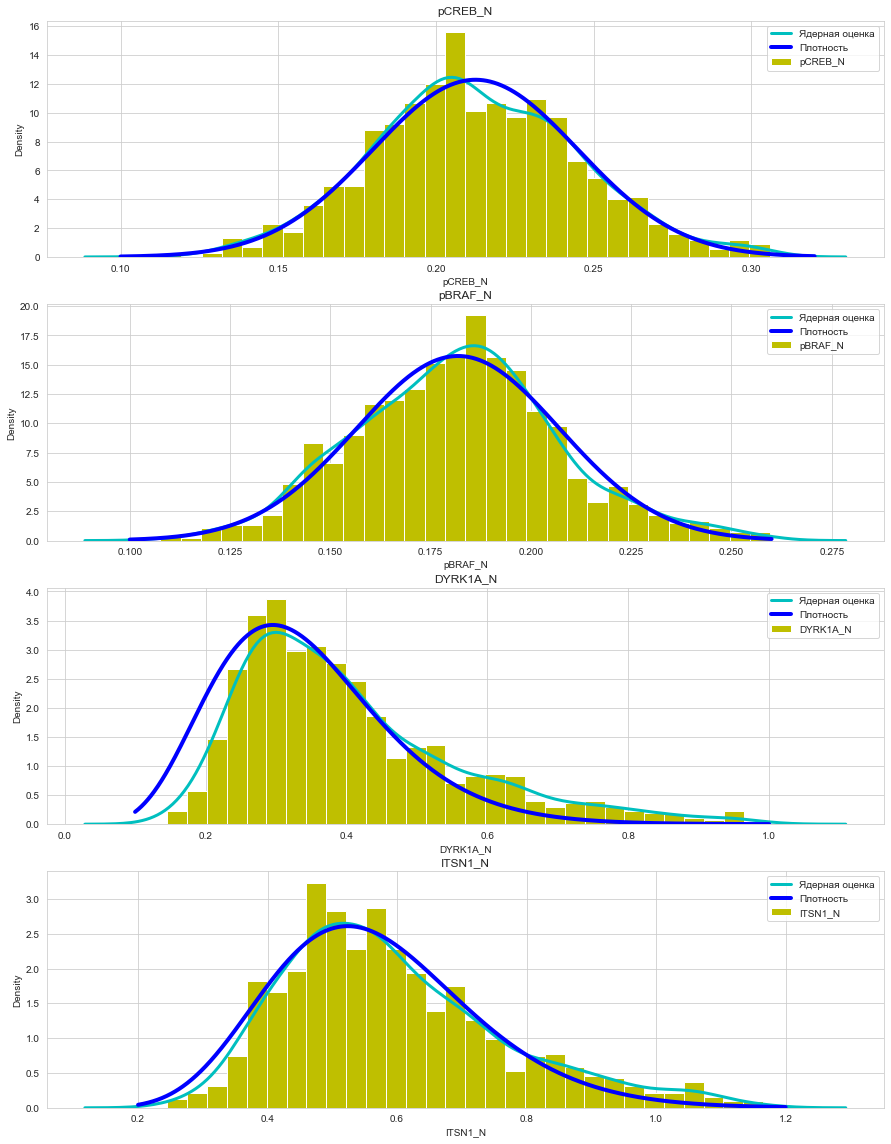

In [ ]:

beta = { 'ITSN1_N': 12.8998, 'DYRK1A_N': 7.5979} 
grids = [np.linspace(*i,1000) for i in [[0.1,0.32], [0.1,0.26],[0.1,1],[0.2,1.2]]]
funcs = [sps.norm(est[i],np.sqrt(disp[i])) for i in columns[:2]]
funcs += [sps.gamma(a=beta[i],scale=est[i]) for i in columns[2:]]

fig, ax = plt.subplots(nrows=4, figsize=(15,20))
for a,i,n in zip(ax,columns, range(4)):
    a.hist(np.array(data[i]), label= i, bins=30,density=True, color='y')
    sns.kdeplot(data=data[i], label='Ядерная оценка', color='c',ax=a, lw=3)
    a.plot(grids[n], funcs[n].pdf(grids[n]), color='b', label = 'Плотность', lw=4)
    a.set_title(i)
    a.legend()

**Вывод**

1) В некоторых случаях (контрпример гамма распределение) likelyhood_function удобна и дает хорошие оценки 

2) Ядерная оценка плотности не всегда совпадает с ожидаемым распределением, вероятно, в силу конечности выборки

3) Выборочное среднеее не является универсальным оценочным инструментом, иногда бывают исключения (медиана в коши)

4) Важно держать в голове особенности работы компьютера, точнее про его вычислительные точности и стараться уменьшать количество и сложность операций аналитически, тк это может привести к ошибкам как было показано с логарифмом и с самой функцией правдоподобия.